In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv('Datasets/drugsComTrain_raw.csv')
df_test = pd.read_csv('Datasets/drugsComTest_raw.csv')

### After performing EDA on Drug Reviews, we have decided to perform the following preprocessing steps:
1. Remove instances where condition value is NULL, or Inconsistent.
2. We will analyze only the conditions that have at least 2 drugs per condition.
3. Preprocess the reviews.
4. Classify ratings 1 ~ 5 as negative, and 6 ~ 10 as positive.
5. Normalize usefulcount by conditions.

In [3]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

In [4]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']

In [5]:
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)

new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

In [6]:
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()

In [7]:
all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

In [8]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [9]:
stops = set(stopwords.words('english'))

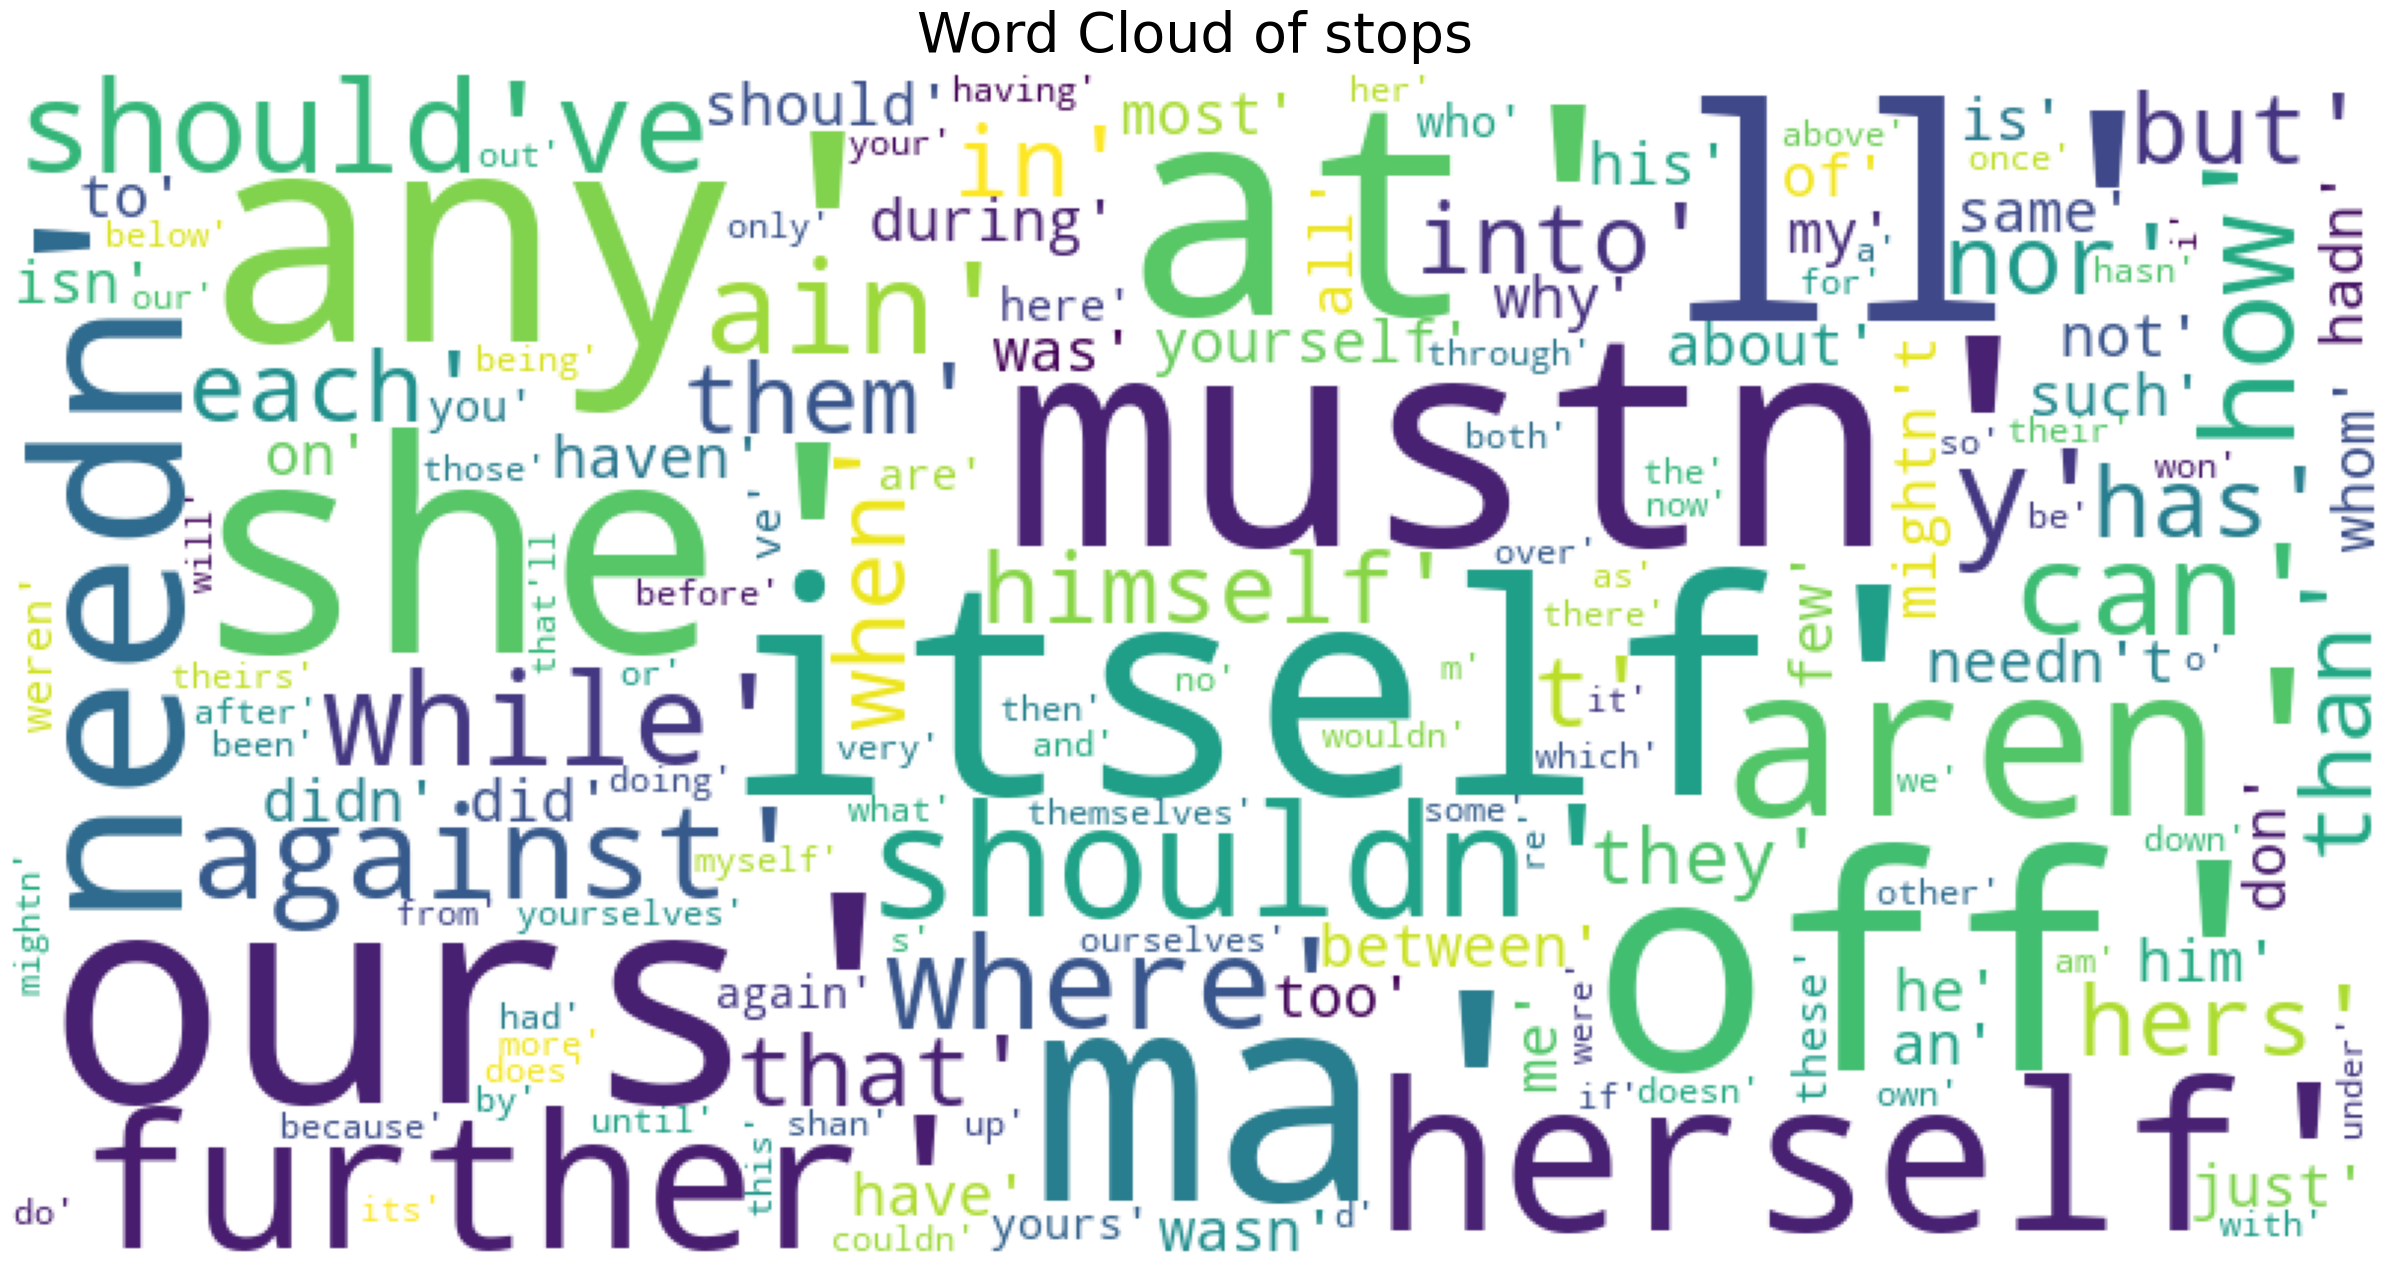

In [10]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(stops, title="Word Cloud of stops")

In [11]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't",
            "no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [12]:
import re

stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

In [13]:
df_all['review_clean'] = df_all['review'].apply(review_to_words)

C:\Users\yuvam\AppData\Local\Temp\ipykernel_213800\289601844.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [14]:
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)

In [15]:
df_all.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,no side effect take combin bystol mg fish oil,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,son halfway fourth week intuniv becam concern ...,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,use take anoth oral contracept pill cycl happi...,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,first time use form birth control glad went pa...,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,suboxon complet turn life around feel healthie...,1


In [16]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212053 entries, 0 to 212052
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   uniqueID      212053 non-null  int64 
 1   drugName      212053 non-null  object
 2   condition     212053 non-null  object
 3   review        212053 non-null  object
 4   rating        212053 non-null  int64 
 5   date          212053 non-null  object
 6   usefulCount   212053 non-null  int64 
 7   review_clean  212053 non-null  object
 8   sentiment     212053 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 14.6+ MB


In [17]:
# saving the dataframe
# df_all.to_csv('cleaned_DrugReviews.csv')

In [18]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_all, test_size = 0.33, random_state = 42)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2,
                             ngram_range=(4, 4),
                             max_features = 5000
                            )
vectorizer

CountVectorizer(max_features=5000, min_df=2, ngram_range=(4, 4))

In [20]:
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [21]:
train_data_features = pipeline.fit_transform(df_train['review_clean'])
test_data_features = pipeline.fit_transform(df_test['review_clean'])

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import random

In [23]:
y_train = df_train['sentiment']
y_test = df_test['sentiment']
solution = y_test.copy()

# Model Structure
model = keras.models.Sequential()

model.add(keras.layers.Dense(200, input_shape=(5000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(200))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 200)                 │       1,000,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200)                 │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 200)                 │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,062,201 (4.05 MB)

 Trainable params: 1,061,401 (4.05 MB)

 Non-trainable params: 800 (3.12 KB)

In [25]:
train_data_features_dense = train_data_features.toarray()
test_data_features_dense = test_data_features.toarray()

Epoch 1/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.6960 - loss: 0.6178
Epoch 2/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7228 - loss: 0.5605
Epoch 3/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7281 - loss: 0.5467
Epoch 4/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7319 - loss: 0.5388
Epoch 5/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7333 - loss: 0.5339
Epoch 6/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7351 - loss: 0.5297
Epoch 7/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7392 - loss: 0.5229
Epoch 8/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7423 - loss: 0.5190
Epoch 9/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.7410 - loss: 0.5192
Epoch 10/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7453 - loss: 0.5130
Epoch 11/30
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7434 - loss: 0.5133
Epoch 12/30
222

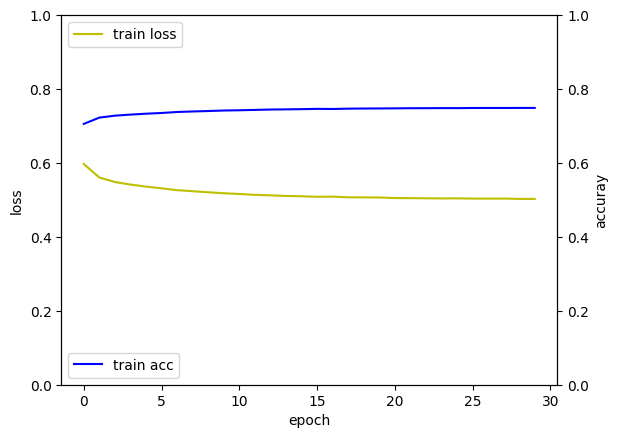

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6690 - loss: 0.8108
loss_and_metrics : [0.8151337504386902, 0.6674811840057373]


In [26]:
# Train model
hist = model.fit(train_data_features_dense, y_train, epochs=30, batch_size=64)

# Traing process
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# Evaluation
loss_and_metrics = model.evaluate(test_data_features_dense, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

In [27]:
sub_preds_deep = model.predict(test_data_features_dense, batch_size=32)

2187/2187 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


#### Now, we will nomalize usefulcount by condition for better reliability. It will help us to calculate the final predicted value and recommend the appropriate drug for each condition according to the order of the value.

In [28]:
# Define the userful_count function as before
def userful_count(data):
    grouped = data.groupby(['condition']).size().reset_index(name='user_size')
    data = pd.merge(data, grouped, on='condition', how='left')
    return data

# Process df_test
df_test = userful_count(df_test) 
df_test['usefulCount'] = df_test['usefulCount'] / df_test['user_size']

# Use deep learning predictions
df_test['deep_pred'] = sub_preds_deep

# Compute total prediction scaled by usefulCount
df_test['total_pred'] = df_test['deep_pred'] * df_test['usefulCount']

# Aggregate by condition and drugName
df_test = df_test.groupby(['condition', 'drugName']).agg({'total_pred': ['mean']})

# Display the final DataFrame
df_test

total_pred
                                                       mean
condition                drugName                          
ADHD                     Adderall                  0.023424
                         Adderall XR               0.015477
                         Adzenys XR-ODT            0.003771
                         Amantadine                0.003657
                         Amphetamine               0.004938
...                                                     ...
moterol)                 Arformoterol              0.640163
                         Budesonide / formoterol   0.715625
von Willebrand's Disease Stimate                   4.761062
zen Shoulde              Nabumetone               11.672589
                         Naproxen                  0.453449

[5773 rows x 1 columns]

In [29]:
df_test.to_csv('recommended_medicines.csv')